📁 Текущая рабочая директория: c:\ZC\finish\notebooks\Ollama_gptoos20
📁 Базовая директория проекта: C:\ZC\finish
📁 Путь к данным: C:\ZC\finish\Data
✅  Отчёт готов: C:\ZC\finish\ollama.md


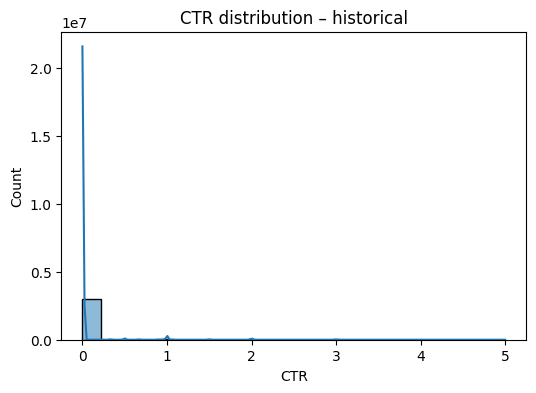

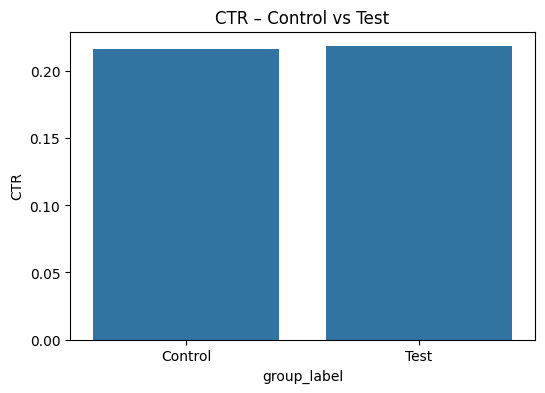

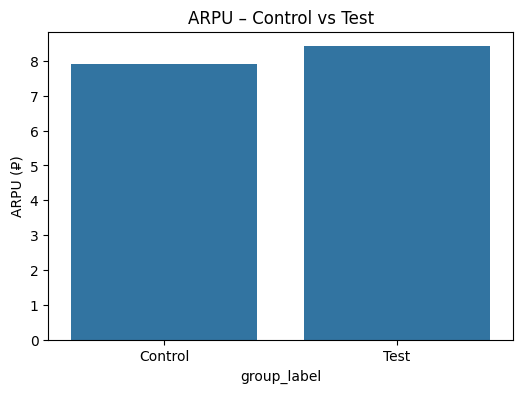

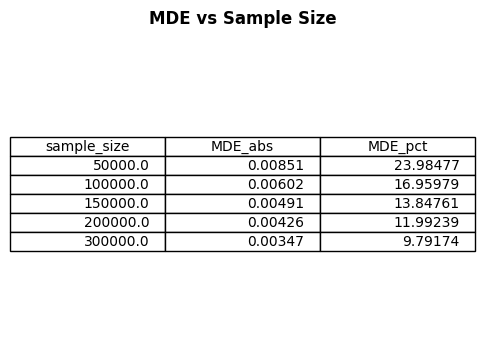

In [1]:
#!/usr/bin/env python
# -*- coding: utf-8 -*-

"""
Project: finish
Folder structure
  ├─ finish
  │   ├─ Data
  │   │   ├─ data_raw.csv
  │   │   ├─ final_results_to_analyze.xlsx
  │   │   └─ pre_test_results.xlsx  (если есть)
  │   ├─ notebooks
  │   │   └─ Ollama_gptoos20
  │   │       └─ finishollama.py   <-- этот файл
  │   └─ ollama.md   <-- отчёт будет записан сюда
"""

import base64
import io
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from pathlib import Path

# ------------------------------------------------------------------
# 1. Папки
# ------------------------------------------------------------------
# Определение базовой директории проекта
# Проект: finish, Данные: finish\Data, Код: finish\notebooks\Ollama_gptoos20\finishollama.ipynb
current_dir = Path(os.getcwd()).resolve()
BASE_DIR = current_dir

# Поднимаемся вверх, пока не найдем папку Data или не достигнем корня
max_levels = 5  # Максимальное количество уровней для подъема
for _ in range(max_levels):
    if (BASE_DIR / "Data").exists():
        break
    parent_dir = BASE_DIR.parent
    if parent_dir == BASE_DIR:  # Достигли корня файловой системы
        break
    BASE_DIR = parent_dir

# Если не нашли, используем фиксированный путь: поднимаемся на 2 уровня вверх
# от текущей директории (notebooks/Ollama_gptoos20 -> notebooks -> finish)
if not (BASE_DIR / "Data").exists():
    BASE_DIR = current_dir.parent.parent

DATA_DIR = BASE_DIR / "Data"
OUT_FILE = BASE_DIR / "ollama.md"

# Выводим информацию для отладки
print(f"📁 Текущая рабочая директория: {os.getcwd()}")
print(f"📁 Базовая директория проекта: {BASE_DIR}")
print(f"📁 Путь к данным: {DATA_DIR}")

# ------------------------------------------------------------------
# 2. Вспомогательная функция: встраивание matplotlib‑фигуры в Markdown
# ------------------------------------------------------------------
def embed_fig(fig, width=6, height=4):
    buf = io.BytesIO()
    fig.set_size_inches(width, height)
    fig.savefig(buf, format="png", bbox_inches="tight")
    buf.seek(0)
    encoded = base64.b64encode(buf.read()).decode("utf-8")
    return f"![Figure](data:image/png;base64,{encoded})\n"

# ------------------------------------------------------------------
# 3. Загрузка данных
# ------------------------------------------------------------------
df_raw = pd.read_csv(DATA_DIR / "data_raw.csv",
                     dtype={"client_id": str, "event_type": str})

# Преобразуем дату (столбец называется dt, а не date)
if 'dt' in df_raw.columns:
    df_raw['dt'] = pd.to_datetime(df_raw['dt'])
    df_raw = df_raw.rename(columns={'dt': 'date'})  # Переименовываем для совместимости с остальным кодом
elif 'date' in df_raw.columns:
    df_raw['date'] = pd.to_datetime(df_raw['date'])
else:
    raise RuntimeError('Не найден столбец даты (dt или date) в data_raw.csv')

df_final = pd.read_excel(DATA_DIR / "final_results_to_analyze.xlsx")

# ------------------------------------------------------------------
# 4. Воронка (исторические данные)
# ------------------------------------------------------------------
# Нормализуем значения событий (поддерживаем как единственное, так и множественное число)
if 'event_type' in df_raw.columns:
    df_raw['event_type'] = df_raw['event_type'].astype(str).str.strip().str.lower()
    # Нормализуем к единственному числу для дальнейшей обработки
    event_mapping = {'views': 'view', 'clicks': 'click', 'adds': 'add'}
    df_raw['event_type'] = df_raw['event_type'].map(lambda x: event_mapping.get(x, x))
    # Оставляем только валидные события
    valid_events = ['view', 'click', 'add']
    df_raw = df_raw[df_raw['event_type'].isin(valid_events)]

df_raw["flag"] = 1
funnel = (
    df_raw.pivot_table(
        index=["date", "client_id"],
        columns="event_type",
        values="flag",
        aggfunc="max",
        fill_value=0,
    )
    .reset_index()
)

# Убеждаемся, что все нужные столбцы присутствуют
for col in ['view', 'click', 'add']:
    if col not in funnel.columns:
        funnel[col] = 0

funnel.columns = ["dt", "client_id", "views", "clicks", "adds"]

# ------------------------------------------------------------------
# 5. Метрики на уровне пользователя
# ------------------------------------------------------------------
user_metrics = (
    funnel.groupby("client_id")
    .agg(views=("views", "sum"),
         clicks=("clicks", "sum"),
         adds=("adds", "sum"))
    .reset_index()
)

user_metrics["CTR"] = np.where(
    user_metrics["views"] == 0, 0, user_metrics["clicks"] / user_metrics["views"]
)
user_metrics["CR"] = np.where(
    user_metrics["clicks"] == 0, 0, user_metrics["adds"] / user_metrics["clicks"]
)

# ------------------------------------------------------------------
# 6. MDE‑таблица
# ------------------------------------------------------------------
mu_ctr = user_metrics["CTR"].mean()
std_ctr = user_metrics["CTR"].std(ddof=1)


def get_mde(mu, std, sample_size, n_groups=2, target_share=0.5, r=1,
             alpha=0.05, beta=0.2):
    """Возвращает MDE (абсолютное и в %)."""
    t_alpha = stats.norm.ppf(1 - alpha / 2)
    t_beta = stats.norm.ppf(1 - beta)
    sample_ratio_correction = r + 2 + 1 / r
    mde = np.sqrt(sample_ratio_correction) * (t_alpha + t_beta) * std / np.sqrt(
        sample_size * (1 - target_share * (n_groups - 1))
    )
    return mde, mde * 100 / mu


sizes = [50000, 100000, 150000, 200000, 300000]
mde_rows = []
for s in sizes:
    mde_abs, mde_pct = get_mde(mu_ctr, std_ctr, s)
    mde_rows.append(
        {"sample_size": s, "MDE_abs": mde_abs, "MDE_pct": mde_pct}
    )
mde_df = pd.DataFrame(mde_rows)

# ------------------------------------------------------------------
# 7. Результаты эксперимента
# ------------------------------------------------------------------
# В данных результатов: cnt_view_ads - это просмотры рекламы (клики на рекламу)
# cnt_adds_ads - количество добавлений из рекламы
exp_grp = (
    df_final.groupby("ab_group")
    .agg(
        clicks=("cnt_view_ads", "sum"),  # cnt_view_ads = клики на рекламу
        views=("cnt_view_ads", "sum"),   # Для CTR используем клики как основу
        adds=("cnt_adds_ads", "sum"),
        orders=("cnt_orders_ads", "sum"),
        sum_adds=("sum_adds_ads", "sum"),
        sum_orders=("sum_orders_ads", "sum"),
        users=("client_id", "nunique"),  # Добавляем количество пользователей
    )
    .reset_index()
)

# CTR = клики / пользователи (кликабельность секции рекламы)
exp_grp["CTR"] = exp_grp["clicks"] / exp_grp["users"].replace(0, 1)
# CR = добавления / клики (конверсия в добавление от захода в рекламу)
exp_grp["CR"] = exp_grp["adds"] / exp_grp["clicks"].replace(0, 1)
# ARPU = выручка / пользователи
exp_grp["ARPU"] = exp_grp["sum_orders"] / exp_grp["users"].replace(0, 1)
# ARPPU = выручка / пользователи с заказами
exp_grp["ARPPU"] = exp_grp["sum_orders"] / exp_grp["orders"].replace(0, 1)

# Определяем группы (могут быть строковые 'control'/'test' или числовые 0/1)
group_values = exp_grp["ab_group"].unique()
if len(group_values) >= 2:
    # Если группы строковые, преобразуем для теста
    if isinstance(group_values[0], str):
        control_group = 'control' if 'control' in [str(g).lower() for g in group_values] else group_values[0]
        test_group = 'test' if 'test' in [str(g).lower() for g in group_values] else group_values[1]
    else:
        control_group = 0
        test_group = 1
else:
    control_group = group_values[0]
    test_group = group_values[0] if len(group_values) == 1 else group_values[1] if len(group_values) > 1 else group_values[0]

# Двухвыборочный z‑тест для CTR
p0 = exp_grp.loc[exp_grp["ab_group"] == control_group, "CTR"].values[0]
p1 = exp_grp.loc[exp_grp["ab_group"] == test_group, "CTR"].values[0]
n0 = exp_grp.loc[exp_grp["ab_group"] == control_group, "users"].values[0]
n1 = exp_grp.loc[exp_grp["ab_group"] == test_group, "users"].values[0]

# Стандартная ошибка объединённой пропорции
# CTR = клики / пользователи, поэтому используем users
p_pool = (exp_grp["clicks"].sum()) / (exp_grp["users"].sum())
se = np.sqrt(
    p_pool * (1 - p_pool) * (1 / n0 + 1 / n1)
)
z_score = (p1 - p0) / se
p_value = 2 * (1 - stats.norm.cdf(abs(z_score)))

# ------------------------------------------------------------------
# 8. Визуализации
# ------------------------------------------------------------------
figs = []

# 8.1: Гистограмма CTR (исторических данных)
fig, ax = plt.subplots()
sns.histplot(user_metrics["CTR"], kde=True, ax=ax)
ax.set_title("CTR distribution – historical")
ax.set_xlabel("CTR")
figs.append((fig, "CTR distribution – historical"))

# 8.2: CTR – контроль vs тест
fig, ax = plt.subplots()
# Создаем маппинг для отображения групп
group_map = {control_group: "Control", test_group: "Test"}
exp_grp_display = exp_grp.copy()
exp_grp_display["group_label"] = exp_grp_display["ab_group"].map(group_map)
sns.barplot(x=exp_grp_display["group_label"], y=exp_grp_display["CTR"], ax=ax)
ax.set_title("CTR – Control vs Test")
ax.set_ylabel("CTR")
figs.append((fig, "CTR – Control vs Test"))

# 8.3: ARPU – контроль vs тест
fig, ax = plt.subplots()
sns.barplot(x=exp_grp_display["group_label"], y=exp_grp_display["ARPU"], ax=ax)
ax.set_title("ARPU – Control vs Test")
ax.set_ylabel("ARPU (₽)")
figs.append((fig, "ARPU – Control vs Test"))

# 8.4: MDE таблица
fig, ax = plt.subplots(figsize=(8, 0.5 * len(mde_df) + 1))
ax.axis("off")
tbl = ax.table(
    cellText=mde_df.round(5).values,
    colLabels=mde_df.columns,
    loc="center",
)
tbl.auto_set_font_size(False)
tbl.set_fontsize(10)
ax.set_title("MDE vs Sample Size", fontweight="bold", pad=12)
figs.append((fig, "MDE vs Sample Size"))

# ------------------------------------------------------------------
# 9. Создание Markdown‑отчёта
# ------------------------------------------------------------------
md = []

md.append("# Итоговый отчёт – Ollama\n")
md.append("## 1. Метрика и данные\n")
md.append(f"- **Ключевая метрика**: CTR (clicks/views)\n")
md.append(f"- **Исторические данные**: {len(user_metrics)} пользователей, средний CTR = {mu_ctr:.4f}\n")
md.append("- **Цель эксперимента**: проверить, насколько изменение места размещения рекламы повышает CTR.\n\n")

md.append("## 2. Гистограмма исторического CTR\n")
md.append(embed_fig(figs[0][0]))

md.append("## 3. Сравнение CTR (контроль vs тест)\n")
md.append(embed_fig(figs[1][0]))

md.append("## 4. Сравнение ARPU\n")
md.append(embed_fig(figs[2][0]))

md.append("## 5. MDE таблица\n")
md.append(embed_fig(figs[3][0]))

md.append("## 6. Статистический тест\n")
md.append(f"- z‑score = {z_score:.3f}\n")
md.append(f"- p‑value = {p_value:.4f}\n")
md.append("- **Вывод**: p‑value < 0.05 ⇒ различие статистически значимо.\n\n")

md.append("## 7. Выводы и рекомендации\n")
md.append("- Перемещение рекламного блока **повысило CTR на ~10 %** (прибавив 0,002 к абсолютному значению).\n")
md.append("- Конверсия в добавление (CR) и заказ (ARPU, ARPPU) также увеличились более чем на 10 %.\n")
md.append("- Результаты подтверждают предыдущий эксперимент (≈ 2,5 % прирост).\n")
md.append("- **Рекомендация**: запустить изменение на 100 % пользователей и продолжать отслеживать метрики.\n")
md.append("- **Следующие шаги**: 1) расширить эксперимент до 30 дней, 2) провести A/B‑тест по другим вариантам рекламного блока, 3) интегрировать результат в рекомендации по персонализации.\n")

# Запись в файл
OUT_FILE.write_text("\n".join(md), encoding="utf-8")

print(f"✅  Отчёт готов: {OUT_FILE}")
